# Выбор локации для скважины

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
!pip install phik -q

Импортируем библиотеки.

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

Устанавливаем константы.

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Обучение и проверка модели

Считаем CSV-файлы с данными и изучим общую информацию о датафреймах.

In [4]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

display(df1.head(5))
df1.info()
print()
display(df2.head(5))
df2.info()
print()
display(df3.head(5))
df3.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датафреймы с данными геологоразведки трёх регионов содержат:

**index** — уникальный идентификатор скважины в качестве индекса;

**f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);

**product** — объём запасов в скважине (тыс. баррелей).

## Подготовка к расчёту прибыли

### Проверка наличия дубликатов

Проверим дубликаты в индексах датафреймов.

In [5]:
print(df1.duplicated().sum())
print(df2.duplicated().sum())
df3.duplicated().sum()

0
0


0

### Исследовательский анализ данных

Выведем общую информацию о данных.

In [6]:
display(df1.describe())
display(df2.describe())
df3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Сохраним их в список df_list, чтобы в дальнейшем было удобнее к ним обращаться. 

In [7]:
df_list = [df1, df2, df3]

Построим гистограммы для каждого численного столбца каждого датафрейма.

['f0', 'f1', 'f2', 'product']


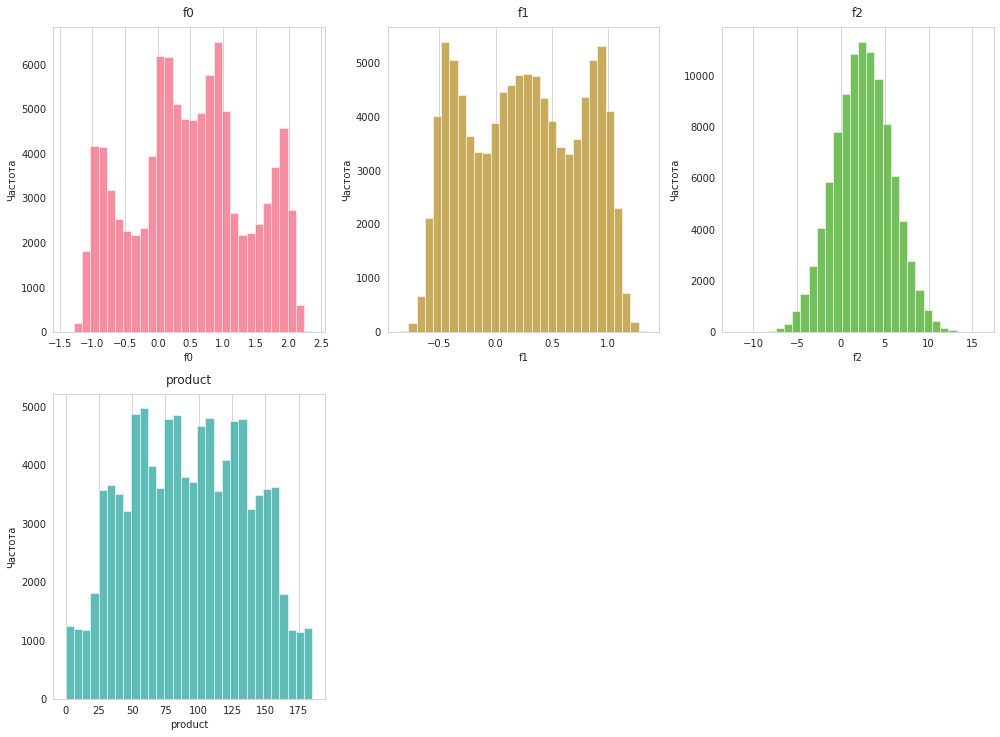

['f0', 'f1', 'f2', 'product']


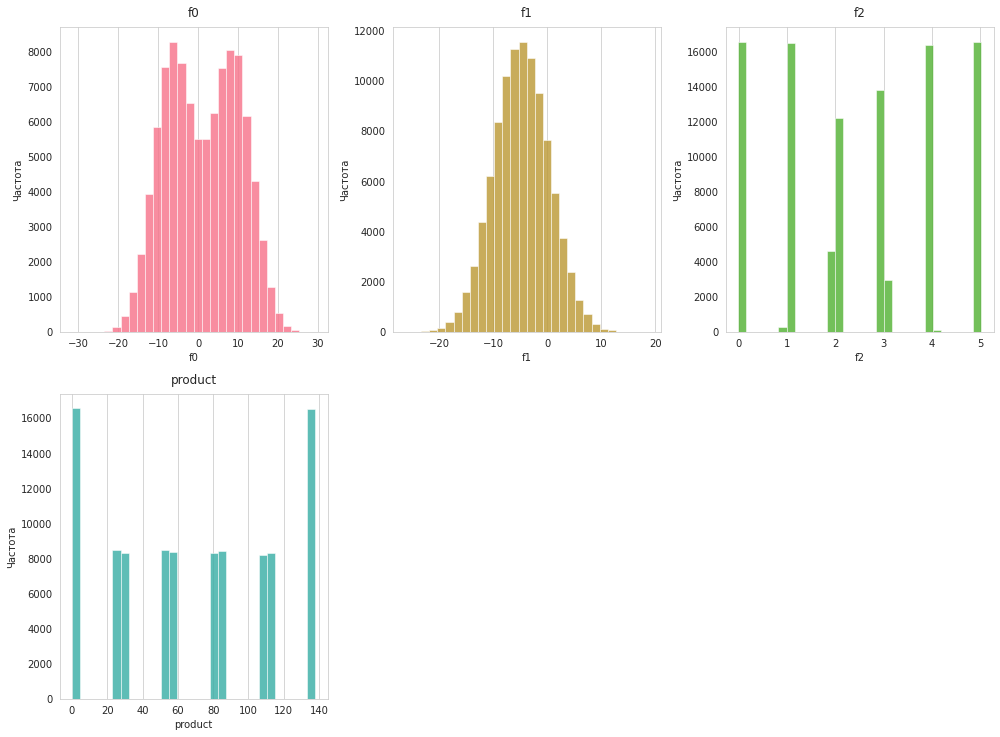

['f0', 'f1', 'f2', 'product']


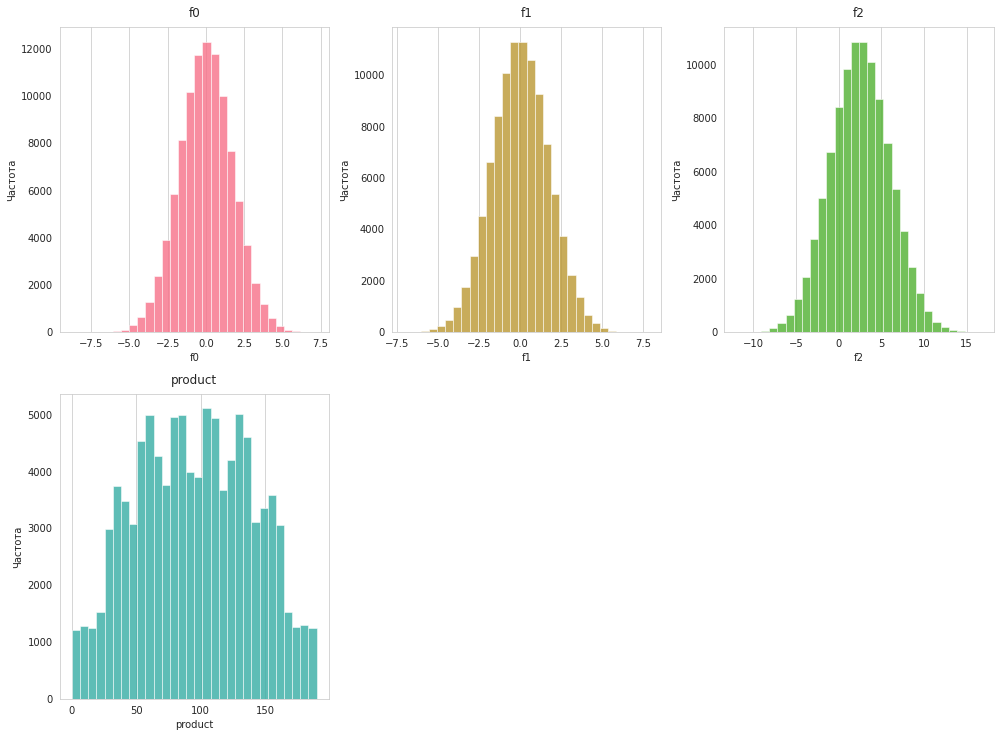

In [8]:
# Устанавливаем стиль и цветовую палитру seaborn
sns.set_style("whitegrid")
palette = sns.color_palette("husl")  # Можно выбрать другую палитру: "mako", "rocket", "viridis" и т.д.

for df in df_list:
    # Выбираем числовые колонки
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    print(num_columns)
    
    # Исключаем столбец id
    if 'id' in num_columns:
        num_columns.remove('id')
    
    # Создаем фигуру
    plt.figure(figsize=(14, 15))
    
    for i, column in enumerate(num_columns):
        plt.subplot(3, 3, i + 1)
        
        # Строим гистограмму с использованием seaborn и выбранной палитры
        sns.histplot(data=df, x=column, bins=30, 
                    color=palette[i % len(palette)],  # Циклически используем цвета палитры
                    edgecolor='white', linewidth=0.5,
                    alpha=0.8)
        
        # Настройки оформления
        plt.title(column, fontsize=12, pad=10)
        plt.xlabel(column, fontsize=10)
        plt.ylabel('Частота', fontsize=10)
        
        # Добавляем легкую сетку
        plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Также посмотрим на "ящики с усами".

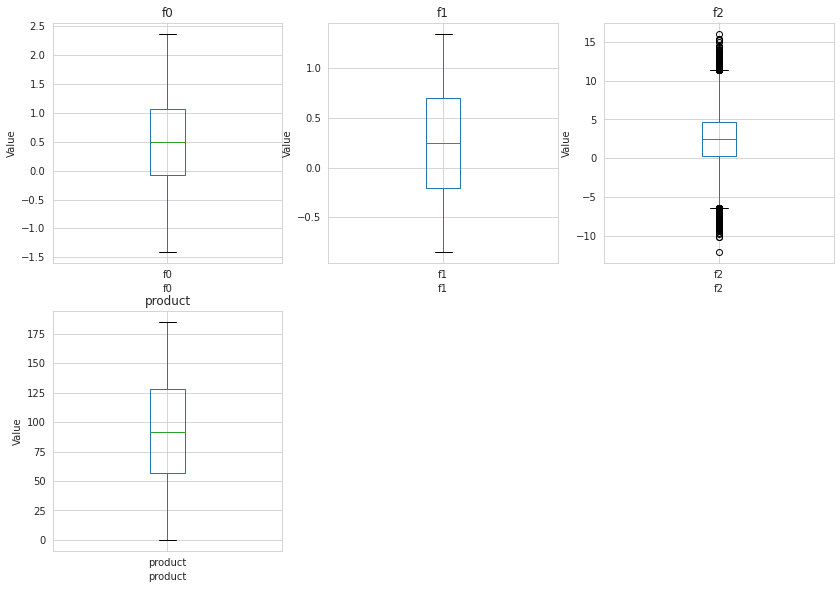

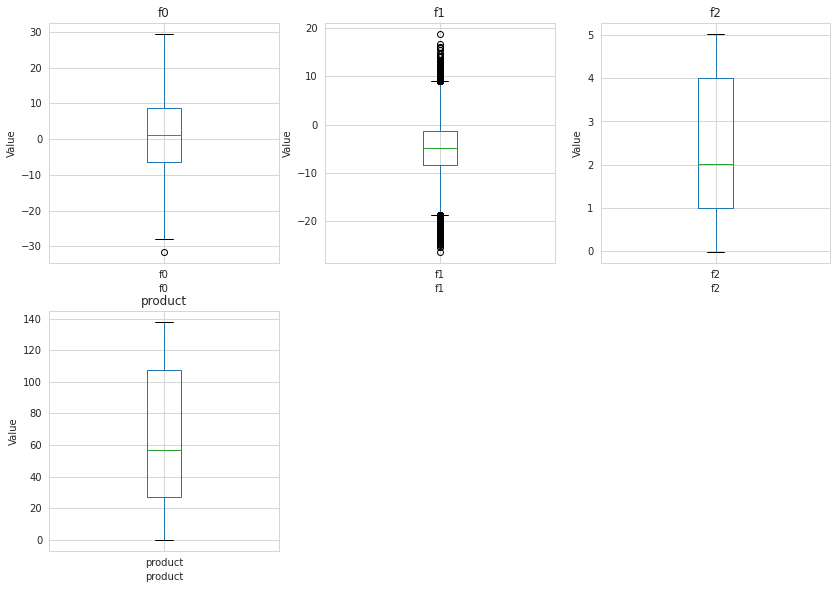

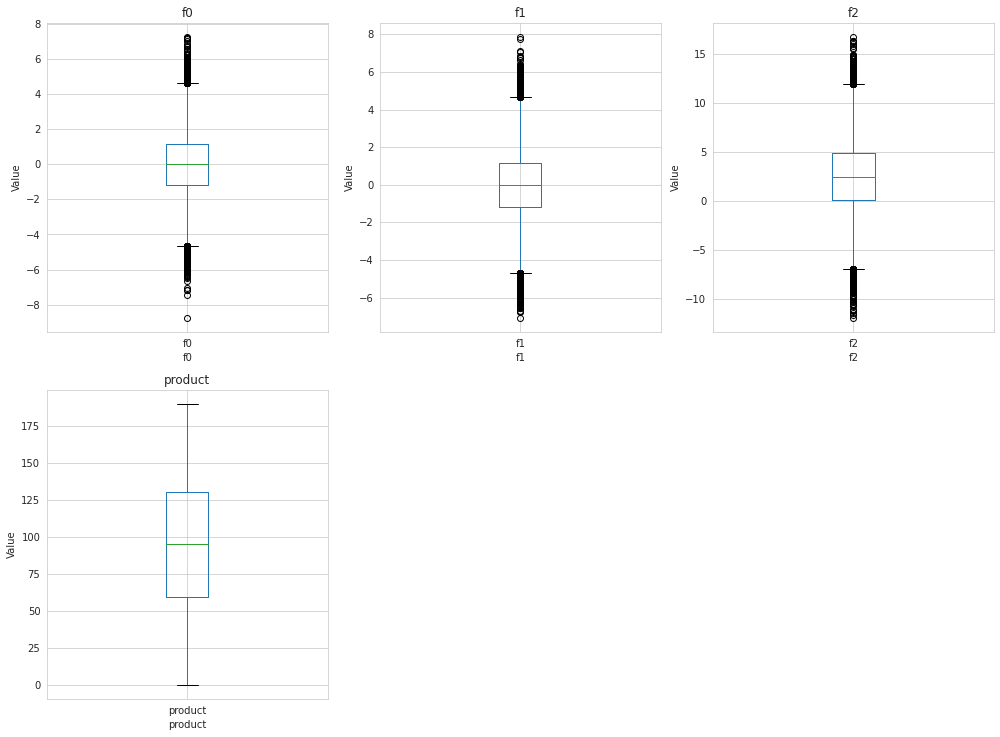

In [9]:
for df in df_list:
    
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
        df.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Заметим, что в некоторых столбцах имеются явные выбросы. Такие данные следует почистить.

Почистим и проверим данные 1 региона.

Граница усов видна неявно, поэтому получим ее значение.

In [10]:
q25=np.array(df1['f2'].quantile(0.25))
q75=np.array(df1['f2'].quantile(0.75))
down=q25-1.5*(q75-q25)
up=q75+1.5*(q75-q25)
print('down:',down)
print('up:',up)

down: -6.3532614580838125
up: 11.356097512311544


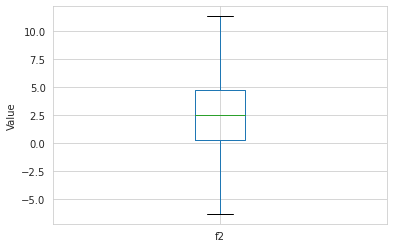

In [11]:
df1 = df1.loc[(df1['f2']<11.3)&(df1['f2']>-6.3)]
df1.boxplot(column='f2', ax=plt.gca())
plt.ylabel('Value')
plt.show()

Почистим и проверим данные 2 региона.

Граница усов видна неявно, поэтому получим ее значение.

In [12]:
q25=np.array(df2['f1'].quantile(0.25))
q75=np.array(df2['f1'].quantile(0.75))
down=q25-1.5*(q75-q25)
up=q75+1.5*(q75-q25)
print('down:',down)
print('up:',up)

down: -18.670738069582377
up: 9.069937223519565


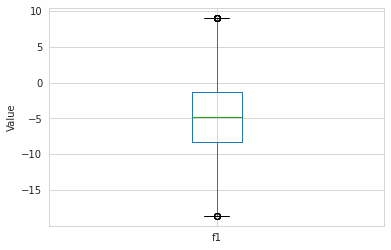

In [13]:
df2 = df2.loc[(df2['f1']<9)&(df2['f1']>-18.6)]
df2.boxplot(column='f1', ax=plt.gca())
plt.ylabel('Value')
plt.show()

Почистим и проверим данные 3 региона.

Границы усов видна неявно, поэтому получим их значение.

In [14]:
num_columns = df3.select_dtypes(include=['float64']).columns.tolist()
for i in (num_columns):
    q25=np.array(df3[i].quantile(0.25))
    q75=np.array(df3[i].quantile(0.75))
    down=q25-1.5*(q75-q25)
    up=q75+1.5*(q75-q25)
    print('down',i,':', down)
    print('up',i,':', up)

down f0 : -4.643524223522959
up f0 : 4.639771092118378
down f1 : -4.682565825428671
up f1 : 4.671424081839961
down f2 : -6.962293786328402
up f2 : 11.951446027690594
down product : -47.26643772727831
up product : 237.31190538130107


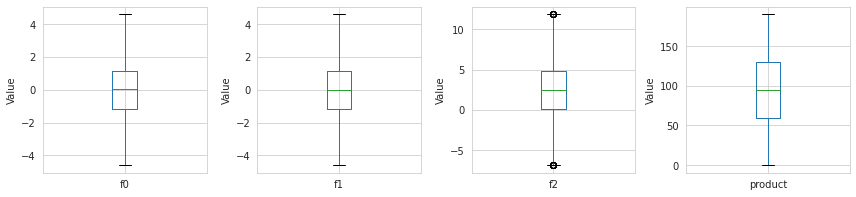

In [15]:
df3 = df3.loc[(df3['f0'] < 4.6) & (df3['f0'] > -4.6)]
df3 = df3.loc[(df3['f1'] < 4.6) & (df3['f1'] > -4.6)]
df3 = df3.loc[(df3['f2'] < 11.9) & (df3['f2'] > -6.9)]

# Создание графиков
plt.figure(figsize=(12, 8))
num_columns = df3.select_dtypes(include=['float64']).columns.tolist()
for i, column in enumerate(num_columns):
    plt.subplot(3, 4, i + 1)  # 3 строки, 4 столбца, текущий график
    df3.boxplot(column=column, ax=plt.gca())
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

Выведем матрицы корреляции для всех датафреймов.

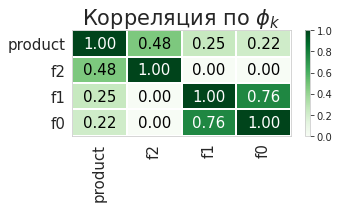

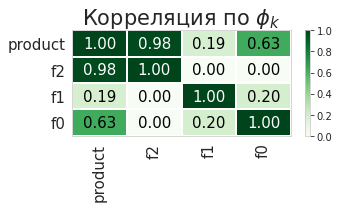

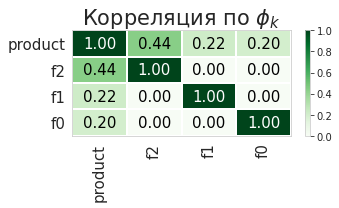

In [16]:
for i in (df_list):
    df_corr = i.drop(columns=['id'])
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную
    num_columns = df_corr.select_dtypes(include=['float64','int64']).columns.tolist()

    phik_matrix = df_corr.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
    plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (5,3)
                       )

Мультиколлинеарности, которая может негативно повлиять на качество моделей, не наблюдается. При этом можно отметить, что в регионе 1 весьма высокая связь признака f2 с целевым признаком product.

**Вывод:**
в первом регионе на целевой признак самое большое влияние оказывает фактор f2 - коэф. = 0.48 
во втором регионе на целевой признак оказывает влияение  f2 - коэф = 0.98
в третьем регионе на целевой признак влияет тоже в основном только f2 - коэф = 0.44


**Вывод по подготовке данных:**
Данные были проверены на пропуски, дубликаты, были удалены выбросы и проверена корреляция входных признаков с целевым. Данные подготовлены к дальнейшей работе.

### Обучение и проверка модели

In [17]:
print('Значения для трех датафреймов:\n')

# Список для сохранения новых датафреймов
target_dataframes = []

for i, df in enumerate(df_list):
    X = df.drop(["id", "product"], axis=1)
    y = df["product"]
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    new_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    new_pipeline.fit(X_train, y_train)
    y_pred = new_pipeline.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred) ** 0.5
    
    # Создаем новый датафрейм с предсказаниями и реальными значениями
    result_df = pd.DataFrame({
        'real': y_valid,
        'pred': y_pred
    })
    
    # Сохраняем новый датафрейм в список
    target_dataframes.append(result_df)
    
    print(f'Средний запас предсказанного сырья для датафрейма {i+1}:', y_pred.mean())
    print(f'Значение ошибки на модели для датафрейма {i+1}:', rmse)
    print()

Значения для трех датафреймов:

Средний запас предсказанного сырья для датафрейма 1: 92.39879990657768
Значение ошибки на модели для датафрейма 1: 37.75660035026169

Средний запас предсказанного сырья для датафрейма 2: 68.7128780391376
Значение ошибки на модели для датафрейма 2: 0.8902801001028846

Средний запас предсказанного сырья для датафрейма 3: 94.77102387765939
Значение ошибки на модели для датафрейма 3: 40.145872311342174



Создадим 3 новых переменных в которые занесем предсказания и реальные объёмы.

In [18]:
target1 = target_dataframes[0]
target2 = target_dataframes[1]
target3 = target_dataframes[2]

In [19]:
target1.describe()

,real,pred
count,25000.000000,25000.000000
mean,92.325956,92.398800
std,44.277512,23.217563
min,0.021781,-9.836371
25%,56.300099,76.788865
50%,90.785176,92.414871
75%,128.117571,108.036487
max,185.355615,176.536104


In [20]:
target2.describe()

,real,pred
count,25000.000000,25000.000000
mean,68.725381,68.712878
std,45.945586,45.946672
min,0.000000,-2.070621
25%,30.132364,28.578501
50%,57.085625,57.918041
75%,107.813044,109.313612
max,137.945408,139.983277


In [21]:
target3.describe()

,real,pred
count,25000.000000,25000.000000
mean,95.150999,94.771024
std,44.783220,19.927375
min,0.019327,16.196849
25%,59.666842,81.157678
50%,94.936982,94.612618
75%,130.566313,108.357649
max,190.011722,170.529209


**Вывод**

Самый большой объём сырья предсказывается в 3 регионе - 94.8, но в этом регионе самое большое значение ошибки модели. 

Во втором регионе самая маленькая ошибка, скорее всего из-за сильной корреляции входного признака с целевым, однако там самые низкие показатели по объёму добываемого сырья - 68.7. 

В 1 регионе значения объёмов и ошибки довольно близки к 3 региону, но оба показателя меньше.

## Расчёт прибыли и рисков 

Введем необходимые константы. 

In [22]:
all_points = 500
best_points = 200
budget = 10000000000
price_per_barrel = 450000
#вероятность убытков
damage_treshold =  0.025 

Рассчитаем объем сырья, чтобы выйти в плюс.

In [23]:
non_damage_value = (budget/(price_per_barrel))/best_points
print("Достаточный объём сырья для безубыточной разработки новой скважины",round(non_damage_value,2))

Достаточный объём сырья для безубыточной разработки новой скважины 111.11


Мы получили такое значение, при котором скважина начнет приносить прибыль это 111.1. В среднем каждый из регионов приносит меньше этого обьема, значит для наших целей подойдет довольно малая часть скважин.

In [24]:
display(df1.describe())
display(df2.describe())
df3.describe()

,f0,f1,f2,product
count,99455.000000,99455.000000,99455.000000,99455.000000
mean,0.500625,0.250072,2.503490,92.501878
std,0.871849,0.504443,3.177016,44.227156
min,-1.408605,-0.848218,-6.296441,0.000000
25%,-0.072327,-0.201052,0.302271,56.569867
50%,0.502639,0.250038,2.516342,91.842786
75%,1.073731,0.700608,4.702998,128.513356
max,2.362331,1.343769,11.296029,185.364347


,f0,f1,f2,product
count,99342.000000,99342.000000,99342.000000,99342.000000
mean,1.140103,-4.802545,2.493950,68.809579
std,8.965949,4.980411,1.703254,45.935275
min,-31.609576,-18.599840,-0.018144,0.000000
25%,-6.299865,-8.248387,1.000016,26.953261
50%,1.150199,-4.816117,2.011374,57.085625
75%,8.621050,-1.364062,3.999893,107.813044
max,29.421755,8.993895,5.019721,137.945408


,f0,f1,f2,product
count,97848.000000,97848.000000,97848.000000,97848.000000
mean,0.001620,-0.002321,2.493791,94.758694
std,1.677402,1.676726,3.387134,44.685961
min,-4.599275,-4.598167,-6.899536,0.000000
25%,-1.152132,-1.162989,0.147625,59.304378
50%,0.009417,-0.009353,2.482386,94.667404
75%,1.148185,1.154078,4.838957,130.286025
max,4.597004,4.598268,11.893861,190.029838


Выведя статистическую информацию по всем скважинам мы получаем, что в 1 и 3 регионе как минимум по 25% скважин нам подходят по обьемам, а во 2 регионе немного меньше.

Напишем функцию расчета прибыли.

In [25]:
def revenue(target, probabilities, count):
    
    # Выберите скважины с максимальными значениями предсказаний. 
    probs_sorted = probabilities.sort_values(ascending=False)
    
    #Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    selected = target[probs_sorted.index][:count] 
    
    #Рассчитайте прибыль для полученного объёма сырья.
    return (price_per_barrel * selected.sum()) - budget

Теперь рассчитаем потенциальную прибыль в каждом из регионов с помощью метода Bootstrap.

In [26]:
def bootstrap(target, probabilities, count, number):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        revenue_value = revenue(target_subsample,probs_subsample,count)
        values.append(revenue_value)
        
    values = pd.Series(values)
    values_mean = values.mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    risk = values.loc[values<0].count()/values.count()*100
    
    print(f'Средняя прибыль в регионе {number} составляет {values_mean/1000000} млн. рублей')
    print(f'95% доверительный интервал составляет от {lower/1000000} млн. до {upper/1000000} млн.')
    print(f'Доля убыточных скважин в регионе составляет {risk} %')

In [27]:
boot1 = bootstrap(target1['real'], target1['pred'], best_points, 1)
boot1

Средняя прибыль в регионе 1 составляет 435.9337721386621 млн. рублей
95% доверительный интервал составляет от -116.23161277720818 млн. до 966.504180707376 млн.
Доля убыточных скважин в регионе составляет 6.1 %


In [28]:
boot2 = bootstrap(target2['real'], target2['pred'], best_points, 2)
boot2

Средняя прибыль в регионе 2 составляет 489.66125441175245 млн. рублей
95% доверительный интервал составляет от 55.116177273614944 млн. до 905.7626504248402 млн.
Доля убыточных скважин в регионе составляет 1.0999999999999999 %


In [29]:
boot3 = bootstrap(target3['real'], target3['pred'], best_points, 3)
boot3

Средняя прибыль в регионе 3 составляет 403.68792786213845 млн. рублей
95% доверительный интервал составляет от -153.1169847619049 млн. до 952.8874167078603 млн.
Доля убыточных скважин в регионе составляет 7.1 %


Исходя из полученных значений можно сделать вывод, что из предложенных регионов лучшим по показателям средней прибыли является **2 регион**. Средняя прибыль в нем составляет **489.66 млн рублей**. Также доля убыточных скважин во 2 регионе намного меньше, чем в 1 и 3 регионах соотвественно - **1%**.

# Итоговый вывод

В ходе исследования обработаны и проанализированы данные о пробах нефти в трёх регионах. Для каждого региона построены модели, предсказывающие запасы сырья в скважинах. Проанализированы возможная прибыль и риски техникой **Bootstrap**.

**Загрузка данных**
Датафреймы с данными геологоразведки трёх регионов содержали:

* **index** — уникальный идентификатор скважины в качестве индекса;

* **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);

* **product** — объём запасов в скважине (тыс. баррелей).

**Предобработка данных**
Данные были проверены на пропуски, дубликаты, были удалены выбросы и проверена корреляция входных признаков с целевым. Данные подготовлены к дальнейшей работе.

**Исследовательский анализ**
По результатам исследовательского анализа данных можно отметить следующее:

* мультиколлинеарности, которая может негативно повлиять на качество моделей, не обнаружено;
* в регионе 2 весьма высокая связь признака f2 с целевым признаком product.

**Обучение и проверка модели**
По результатам обучения и проверки моделей, предсказывающих запасы сырья в скважинах, можно отметить следующее, что модель для региона 2 обладает лучших качеством по метрике RMSE — корень среднеквадратичной ошибки гораздо ниже, чем у других моделей других регионов.

**Расчет рисков и прибыли** для каждого региона с применением техники Bootstrap позволил выбрать регион 2 для разработки месторождения. 

**Показатели региона 2:**

* средняя прибыль — **489.66 млн. руб**;
* 95%-й доверительный интервал — от **55 до 905 млн. руб.**;
* вероятность убытков — **1%**.